In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
from keras.optimizers import Adam,rmsprop
from keras.models import Sequential,Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import metrics
from random import sample
import time
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

Using TensorFlow backend.


In [3]:
expr_true = pd.read_csv('truecounts.csv',index_col=0) #truecounts data generated by splatter
cellinfo = pd.read_csv('cellinfo.csv',index_col=0)
expr = pd.read_csv('counts.csv',index_col=0)

In [4]:
X = expr.values[:,:].transpose()
Y = cellinfo['Group'].values
Y = pd.factorize(Y)[0]
K = len(np.unique(Y))
X_true = expr_true.values[:,:].transpose()
print('{} different cell types'.format(K))
ncell = X.shape[0]
ngene = X.shape[1]
X = X.astype('float')
X_true = X_true.astype('float')

5 different cell types


In [5]:
print(np.mean(X==0),np.mean(X_true==0))
print('{} cells and {} genes'.format(ncell,ngene))

0.31238095238095237 0.019
500 cells and 294 genes


#### normalization

In [6]:
libs = X.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_norm = np.dot(norm_factor,X)
X_norm = np.log2(X_norm + 1.)
X_norm = StandardScaler().fit_transform(X_norm)

libs = X_true.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_true_norm = np.dot(norm_factor,X_true)
X_true_norm = np.log2(X_true_norm + 1.)
X_true_norm = StandardScaler().fit_transform(X_true_norm)

In [15]:
tsne = TSNE(n_components = 2,random_state=1)
T_sne_raw = tsne.fit_transform(X_norm)
T_sne_true = tsne.fit_transform(X_true_norm)

Text(0.5, 1.0, 'tsne for raw data')

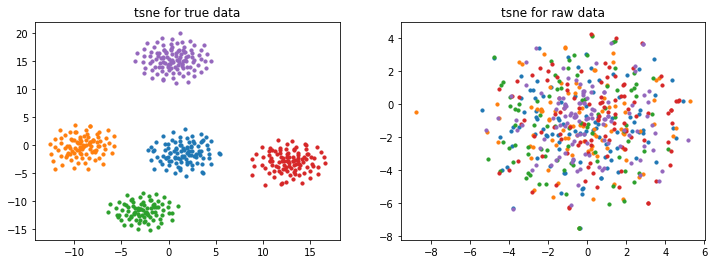

In [16]:
unique_class = np.unique(Y)
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)

for i in range(K):
    plt.scatter(T_sne_true[Y==unique_class[i],0],
                T_sne_true[Y==unique_class[i],1], 
                s=10,label = unique_class[i] )
plt.title('tsne for true data')

fig.add_subplot(122)
for i in range(K):
    plt.scatter(T_sne_raw[Y==unique_class[i],0],
                T_sne_raw[Y==unique_class[i],1], 
                s=10,label = unique_class[i] )
plt.title('tsne for raw data')

#### 0 pattern

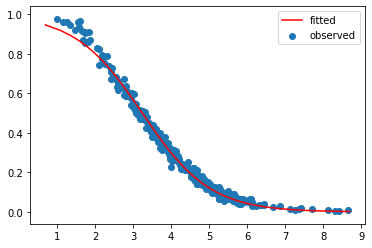

In [26]:
x = X.sum(axis=0)
x = x/((X!=0).sum(axis=0))
y = (X==0).mean(axis=0)
plt.scatter(np.log(x+1),y,label = 'observed')
xx = np.log(np.linspace(1,6000,6000)+1)
yy = 1/(1+np.exp(1.122849*(xx-3.244599)))
plt.plot(xx,yy,color='red',label='fitted')
plt.legend()

#### ordinary autoencoder

In [37]:


t = time.time()
X_imp = np.zeros(shape=(ncell,ngene))
runs = 20
n_input = X.shape[1]
for i in range(runs):
    
    
    #build autoencoder model
    
    model1 = Sequential()
    model1.add(Dense(128,activation = 'relu',
                input_shape = (n_input,)))
    #model1.add(Dense(64,activation='relu'))
    model1.add(Dense(64,activation = 'relu',
                name = 'bottleneck'))
    #model1.add(Dense(64,activation='relu'))
    model1.add(Dense(128,activation='relu'))
    model1.add(Dense(n_input,activation = 'relu'))
    #model training
    model1.compile(loss='mean_squared_error',
                   optimizer=rmsprop())
    model1.fit(X,X,batch_size=32,epochs=200,
           verbose=0,shuffle=True)
    Denoise = Model(model1.input,model1.output)
    X_imp = X_imp + Denoise.predict(X)
    del model1, Denoise
X_imp = X_imp/runs
print('elapse time: {}'.format(time.time()-t))

elapse time: 190.89202117919922


In [38]:
libs = X_imp.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_imp_norm = np.dot(norm_factor,X_imp)
X_imp_norm = np.log2(X_imp_norm + 1.)
for i in range(ngene):
    if np.std(X_imp_norm[:,i])!=0:
        X_imp_norm[:,i] = (X_imp_norm[:,i]-np.mean(X_imp_norm[:,i]))/np.std(X_imp_norm[:,i])

In [39]:
T_sne_imp = tsne.fit_transform(X_imp_norm)


Text(0.5, 1.0, 'tsne for denoised data')

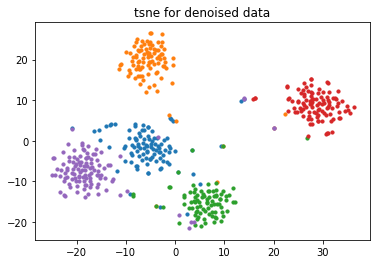

In [40]:
for i in range(K):
    plt.scatter(T_sne_imp[Y==unique_class[i],0],
                T_sne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] )
plt.title('tsne for denoised data')

In [41]:
kmeans = KMeans(n_clusters=K,random_state=1).fit(StandardScaler().fit_transform(T_sne_imp))
print(metrics.adjusted_rand_score(Y,kmeans.labels_))
from sklearn.metrics import silhouette_score
print(silhouette_score(StandardScaler().fit_transform(T_sne_imp),Y))


0.846640456963308
0.5597665


In [42]:
print(np.mean(X_imp[X_true==0]),np.mean(X_imp[(X_true!=0)&(X==0)]))

8.553263537567062e-05 19.898593915123808


In [45]:
np.sum(X_imp.std(axis=0)==0)

75

#### denoised autoencoder

In [28]:
prob_mat = 1/(1+np.exp(1*(np.log(X+1)-3)))

In [29]:


t = time.time()
X_imp = np.zeros(shape=(ncell,ngene))
runs = 20
n_input = X.shape[1]
for i in range(runs):
    
    X_noise = X.copy()
    zero_mask = np.random.binomial(1,1-prob_mat,[ncell,ngene])
    X_noise = X_noise*zero_mask
    
    #build autoencoder model
    
    model1 = Sequential()
    model1.add(Dense(128,activation = 'relu',
                input_shape = (n_input,)))
    #model1.add(Dense(64,activation='relu'))
    model1.add(Dense(64,activation = 'relu',
                name = 'bottleneck'))
    #model1.add(Dense(64,activation='relu'))
    model1.add(Dense(128,activation='relu'))
    model1.add(Dense(n_input,activation = 'relu'))
    #model training
    model1.compile(loss='mean_squared_error',
                   optimizer=rmsprop())
    model1.fit(X_noise,X,batch_size=32,epochs=200,
           verbose=0,shuffle=True)
    Denoise = Model(model1.input,model1.output)
    X_imp = X_imp + Denoise.predict(X)
    del model1, Denoise
X_imp = X_imp/runs
print('elapse time: {}'.format(time.time()-t))

elapse time: 125.42696857452393


In [30]:
libs = X_imp.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_imp_norm = np.dot(norm_factor,X_imp)
X_imp_norm = np.log2(X_imp_norm + 1.)
for i in range(ngene):
    if np.std(X_imp_norm[:,i])!=0:
        X_imp_norm[:,i] = (X_imp_norm[:,i]-np.mean(X_imp_norm[:,i]))/np.std(X_imp_norm[:,i])

In [31]:
tsne = TSNE(n_components=2,random_state=1)
T_sne_imp = tsne.fit_transform(X_imp_norm)

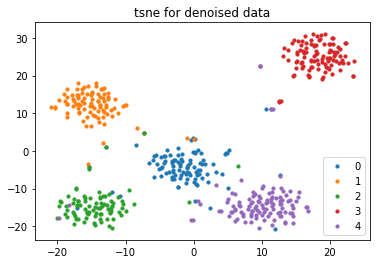

In [33]:
unique_class = np.unique(Y)
for i in range(K):
    plt.scatter(T_sne_imp[Y==unique_class[i],0],
                T_sne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] )
plt.title('tsne for denoised data')
plt.legend()

In [35]:
kmeans = KMeans(n_clusters=K,random_state=1).fit(StandardScaler().fit_transform(T_sne_imp))
print(metrics.adjusted_rand_score(Y,kmeans.labels_))
from sklearn.metrics import silhouette_score
print(silhouette_score(StandardScaler().fit_transform(T_sne_imp),Y))


0.8607695177570719
0.6195059


In [36]:
print(np.mean(X_imp[X_true==0]),np.mean(X_imp[(X_true!=0)&(X==0)]))

0.00016820713306813526 22.39658520646656
